### Methods of unsupervised ML clustering 

- Mean shift 
  -  the advantage of mean shift is that you dont need to know the number of clusters before hand, however it is computationally expensive 
- KMeans algorithm 

### Zero shot learning experimentation

tried with ["sustainable", "unsustainable"] \
tried with ["specifications", "comment"] \
tried with ["specifications", "random"] 

speeding up zero shot learning: 

https://towardsdatascience.com/parallel-inference-of-huggingface-transformers-on-cpus-4487c28abe23 \
https://towardsdatascience.com/hugging-face-transformer-inference-under-1-millisecond-latency-e1be0057a51c \

### Building of Unsupervised Clustering algorithm 

One hot encoding of categorical variables with many categories may lead to the curse of dimensionality problem 
- Use spectral encoding 
https://towardsdatascience.com/spectral-encoding-of-categorical-features-b4faebdf4a

In [1]:
import torch 
torch.cuda.is_available()

True

In [3]:
torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060'

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import pandas as pd 
from nltk.corpus import stopwords 
import math 
import statistics 
from sklearn.feature_extraction.text import CountVectorizer 
from textblob import TextBlob
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import os 
import pandas as pd
from transformers import pipeline
import torch
import time
from datetime import timedelta
import psutil
import ray


class SentimentAnalyser: 
    def __init__(self, dataframes): 
        for df in dataframes: 
            assert df.columns == ["model", "comments", "platform"]
        df_combined = pd.concat(dataframes)
        df_combined['cleaned_comments'] = df_combined['comments'].apply(lambda t: self.preprocess_text(t))
        self.df_combined = df_combined
        self.labels = {
            "zero_shot": "zero_shot", 
            "sentiment_analysis": "sentiment_analysis", 
        }

    def preprocess_text(self, text):
        text = text.lower()                             # all lower case
        text = re.sub(r'\[.*?\]', ' ', text)            # remove text within [ ] (' ' instead of '')
        text = re.sub(r'\<.*?\>', ' ', text)            # remove text within < > (' ' instead of '')
        text = re.sub(r'http\S+', ' ', text)            # remove website ref http
        text = re.sub(r'www\S+', ' ', text)             # remove website ref www

        text = text.replace('€', 'euros')               # replace special character with words
        text = text.replace('£', 'gbp')                 # replace special character with words
        text = text.replace('$', 'dollar')              # replace special character with words
        text = text.replace('%', 'percent')             # replace special character with words
        text = text.replace('\n', ' ')                  # remove \n in text that has it

        text = text.replace('\'', '’')                  # standardise apostrophe
        text = text.replace('&#39;', '’')               # standardise apostrophe

        text = text.replace('’d', ' would')             # remove ’ (for would, should? could? had + PP?)
        text = text.replace('’s', ' is')                # remove ’ (for is, John's + N?)
        text = text.replace('’re', ' are')              # remove ’ (for are)
        text = text.replace('’ll', ' will')             # remove ’ (for will)
        text = text.replace('’ve', ' have')             # remove ’ (for have)
        text = text.replace('’m', ' am')                # remove ’ (for am)
        text = text.replace('can’t', 'can not')         # remove ’ (for can't)
        text = text.replace('won’t', 'will not')        # remove ’ (for won't)
        text = text.replace('n’t', ' not')              # remove ’ (for don't, doesn't)

        text = text.replace('’', ' ')                   # remove apostrophe (in general)
        text = text.replace('&quot;', ' ')              # remove quotation sign (in general)

        text = text.replace('cant', 'can not')          # typo 'can't' (note that cant is a proper word)
        text = text.replace('dont', 'do not')           # typo 'don't'

        text = re.sub(r'[^a-zA-Z0-9]', r' ', text)      # only alphanumeric left
        text = text.replace("   ", ' ')                 # remove triple empty space
        text = text.replace("  ", ' ')                  # remove double empty space

        tokens = TreebankWordTokenizer().tokenize(text)
        tokens = list(map(WordNetLemmatizer().lemmatize, tokens))
        preprocessed_text = " ".join(tokens)

        return preprocessed_text
        
    def Textblob(self): 
        df = self.df_combined.copy() 
        df[self.labels['sentiments_analysis']] = df['comments'].apply(lambda text: TextBlob(text).sentiment.polarity)
        return df 

    def BERTSentimentAnalysis(self): 
        df = self.df_combined.copy() 
        classifier = pipeline("sentiment-analysis") 
        df[self.labels['sentiments_analysis']] = df['comments'].apply(lambda text: classifier(text)[0]['label'])
        return df 
        
    def ZeroShot(self, candidates=["sustainable", "unsustainable"], use_gpu=False): 
        if use_gpu: 
            device_idx = 0
        else: 
            device_idx = -1
        df = self.df_combined.copy() 
        # classifier = pipeline("zero-shot-classification", device=0)
        classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3", device=device_idx)
        df[self.labels['zero_shot']] = df['comments'].apply(lambda text: classifier(text, candidate_labels=candidates)[0]['label']) 
        return df

    def get_topwords(dataframesgroupby_model=True): 

        extra_stopwords = ["wa", "doe", "ha", "video", "one", "subscribe", "channel", "watch", "watching", "thanks", "thank"] 
        all_stopwords = stopwords.words('english')
        all_stopwords.extend(extra_stopwords) 

        return text 
    

# if __name__ == '__main__':
#     df = pd.read_pickle('combined_data.pkl')
#     sentiment_analysis(df)
#     df.to_csv('sentiment_analysis.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Clarence\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Clarence\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data_folder = "support\coffee machine"
data_filename = "combined_data.pkl"
data_filepath = os.path.join(data_folder, data_filename)

df = pd.DataFrame(pd.read_pickle(data_filepath))
df

,0,1,2
0,Let’s Talk About The Breville Bambino Espresso...,1,[very epic morgan. i will watch this later but...
1,Let’s Talk About The Breville Bambino Espresso...,2,[Nice review Morgan! I&#39;m going to order on...
2,The Best Espresso Machine Under £500,1,[How would you say the Rancilio Silvia compare...
3,The Best Espresso Machine Under £500,2,[I wish you linked to the baskets you used. <b...
4,The Best Espresso Machine Under £500,3,"[Thank you so much, your videos very informat..."
...,...,...,...
800,Why Cheap Coffee Makers Suck (And How To Fix T...,91,"[It was hard to tell from the video, but it lo..."
801,Why Cheap Coffee Makers Suck (And How To Fix T...,92,"[James, would you consider simply use the coff..."
802,Why Cheap Coffee Makers Suck (And How To Fix T...,93,"[If you&#39;re externally boiling the water, t..."
803,Why Cheap Coffee Makers Suck (And How To Fix T...,94,[Having not watched this all the way through y...


In [49]:
from transformers import pipeline

candidates = ["sustainable", "unsustainable"]
# classifier = pipeline("zero-shot-classification", device=0)
classifier = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3", device=0)

In [ ]:
comments = df[2]

In [50]:
%%time
classifier(comments[0]+comments[1]+comments[2], candidate_labels=['coffee machine', 'not coffee machine'])

Wall time: 2.16 s


[{'sequence': 'very epic morgan. i will watch this later but im in zoom :)',
  'labels': ['not coffee machine', 'coffee machine'],
  'scores': [0.869458019733429, 0.13054198026657104]},
 {'sequence': 'I watched this in zoom too, what a coincidence',
  'labels': ['not coffee machine', 'coffee machine'],
  'scores': [0.8086419105529785, 0.19135811924934387]},
 {'sequence': '@swingmanic That would be quite a bit of retention, though: I&#39;d say if you don&#39;t like the doser, get rid of it.',
  'labels': ['not coffee machine', 'coffee machine'],
  'scores': [0.8047816753387451, 0.19521833956241608]},
 {'sequence': '@Nick Lai I guess it could be done but I&#39;ve learnt to live with it.',
  'labels': ['not coffee machine', 'coffee machine'],
  'scores': [0.781271755695343, 0.2187281996011734]},
 {'sequence': '@swingmanic Can&#39;t you mod the grinder to become doserless?',
  'labels': ['coffee machine', 'not coffee machine'],
  'scores': [0.6788550019264221, 0.3211449384689331]},
 {'sequ

In [52]:
%%time 

df[3] = df[2].apply(lambda text: classifier(text, candidate_labels=candidates)['labels'][0])

Wall time: 13min 9s


In [54]:
df[3][0]

[{'sequence': 'very epic morgan. i will watch this later but im in zoom :)',
  'labels': ['sustainable', 'unsustainable'],
  'scores': [0.6536259055137634, 0.34637412428855896]},
 {'sequence': 'I watched this in zoom too, what a coincidence',
  'labels': ['sustainable', 'unsustainable'],
  'scores': [0.5213230848312378, 0.4786769151687622]},
 {'sequence': '@swingmanic That would be quite a bit of retention, though: I&#39;d say if you don&#39;t like the doser, get rid of it.',
  'labels': ['sustainable', 'unsustainable'],
  'scores': [0.5466828346252441, 0.45331722497940063]},
 {'sequence': '@Nick Lai I guess it could be done but I&#39;ve learnt to live with it.',
  'labels': ['sustainable', 'unsustainable'],
  'scores': [0.6443400979042053, 0.3556598722934723]},
 {'sequence': '@swingmanic Can&#39;t you mod the grinder to become doserless?',
  'labels': ['unsustainable', 'sustainable'],
  'scores': [0.6100789308547974, 0.389921098947525]},
 {'sequence': '@DJ NC It&#39;s a Rancilio Rocky

C:\Users\Clarence\Documents\School\1. DAI\AI_code\ai_env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


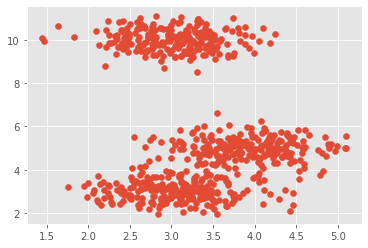

In [74]:
%matplotlib inline
import numpy as np
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.datasets.samples_generator import make_blobs
centers = [[3,3,3],[4,5,5],[3,10,10]]
X, _ = make_blobs(n_samples = 700, centers = centers, cluster_std = 0.5)
plt.scatter(X[:,0],X[:,1])
plt.show()

[[ 2.92734352  2.95552978  3.031273  ]
 [ 3.99308599  5.00144907  5.02786531]
 [ 2.96613058 10.03029845 10.02589725]]
Estimated clusters: 3


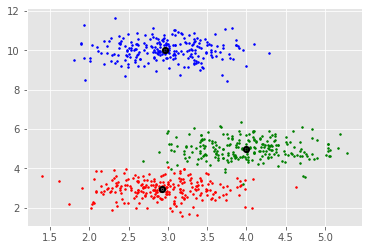

In [29]:
ms = MeanShift()
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Estimated clusters:", n_clusters_)
colors = 10*['r.','g.','b.','c.','k.','y.','m.']
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 3)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
    marker=".",color='k', s=20, linewidths = 5, zorder=10)
plt.show()

### Trying out Meanshift algorithm with TV data

In [62]:
df_uncleaned = pd.read_csv('data/TV.csv')
df_uncleaned.head()

,Title,Price,Sold,Reviews,Condition,Display Technology,Model,Maximum Resolution,Refresh Rate,Features,...,Tuner digital integrated3,Tuner digital integrated4,Functionality Smart TV1,Inputs Audio / Video1,Tuner digital integrated,Functionality Smart TV2,Size,Televisions:Screen_Size_Class,Home_Video:Series,Bundle Description
0,"Insignia 24"" HD 720p Class F20 Series LED Smar...",108.98,143 sold,,"New: A brand-new, unused, unopened, undamaged ...",LED,NS-24DF310NA21,HD (720p),60Hz,Works with Amazon Alexa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"TCL 32"" Class HD LED Android Smart TV 3-Series...",159.99,28 sold,,"New: A brand-new, unused, unopened, undamaged ...",LED,3-Series,720p (HD),NaN,"Dolby Audio, HD Picture Quality, Hey Google / ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"NEW ROKU Smart TV 40"" FHD LED H4030F Series 40...",,,,"New: A brand-new, unused, unopened, undamaged ...",LED,Hisense 43H5500G,1080p (FHD),NaN,Wall Mountable,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Samsung - 43"" Class 7 Series LED 4K UHD Smart ...",275.0,6 watchers,"['I cannot connect to computer, and cannot rep...","New: A brand-new, unused, unopened, undamaged ...",LED,Samsung TU7000,2160p (4K),NaN,"Wi-Fi Enabled, Wall Mountable",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Onn 75"" Class 4k UHD (2160p) LED Frameless Rok...",599.0,,,"New: A brand-new, unused, unopened, undamaged ...",LED,100044717,2160p (4K),60 Hz,Thin Bezel,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
df_uncleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 74 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Title                                     72 non-null     object 
 1   Price                                     71 non-null     object 
 2   Sold                                      72 non-null     object 
 3   Reviews                                   72 non-null     object 
 4   Condition                                 72 non-null     object 
 5   Display Technology                        72 non-null     object 
 6   Model                                     72 non-null     object 
 7   Maximum Resolution                        72 non-null     object 
 8   Refresh Rate                              45 non-null     object 
 9   Features                                  52 non-null     object 
 10  Color                                   

In [133]:
df = df_uncleaned.copy()
df.dropna(axis=1, how='any', thresh=0.9*df.shape[0], inplace=True)
df = df[df.columns[df.nunique() > 1]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               72 non-null     object
 1   Price               71 non-null     object
 2   Sold                72 non-null     object
 3   Reviews             72 non-null     object
 4   Display Technology  72 non-null     object
 5   Model               72 non-null     object
 6   Maximum Resolution  72 non-null     object
 7   Brand               72 non-null     object
 8   Screen Size         71 non-null     object
dtypes: object(9)
memory usage: 5.2+ KB


In [169]:
cols_to_drop = ["Title", "Reviews", "Brand", "Sold", "Model"]
df.drop(cols_to_drop, axis=1, inplace=True)

KeyError: "['Title' 'Reviews' 'Brand' 'Sold' 'Model'] not found in axis"

In [135]:
# df["Energy Star"] = df_uncleaned["Energy Star"]

In [136]:
df_uncleaned["Energy Star"].unique()

array([nan, 'A', 'Not Compliant', '5 Stars', 'Compliant', '1 Star',
       'A+++', '2 Stars', 'A+', 'see pack'], dtype=object)

In [137]:
# df["Price"] = df["Price"].apply(lambda text: str(text).strip())

In [138]:
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

In [144]:
pd.to_numeric(df['Screen Size'].str.extract('(\d+)')[0])

0     24.0
1     32.0
2     40.0
3     43.0
4     75.0
      ... 
67    32.0
68    32.0
69    43.0
70    50.0
71    32.0
Name: 0, Length: 72, dtype: float64

In [145]:
df["Screen Size"] = pd.to_numeric(df['Screen Size'].str.extract('(\d+)')[0], errors="coerce")

In [146]:
df.dropna(inplace=True)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 71
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               59 non-null     float64
 1   Display Technology  59 non-null     object 
 2   Maximum Resolution  59 non-null     object 
 3   Screen Size         59 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.3+ KB


In [148]:
df[["Price", "Screen Size"]] = df[["Price", "Screen Size"]].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [149]:
df.shape

(59, 4)

In [150]:
df

,Price,Display Technology,Maximum Resolution,Screen Size
0,-1.070711,LED,HD (720p),-1.548422
1,-0.956505,LED,720p (HD),-1.069173
3,-0.699012,LED,2160p (4K),-0.410205
4,0.026383,LED,2160p (4K),1.506792
5,0.742823,LED,2160p (4K),0.308669
6,-0.643041,LED,2160p (4K),1.506792
7,2.939137,LED,4320p (8K),1.446886
13,0.577146,QLED,2160p (4K),1.506792
14,-0.493058,LED,2160p (4K),0.009138
15,-0.934117,LED,1080p,-1.069173


In [151]:
df = pd.get_dummies(df, columns = ["Display Technology", "Maximum Resolution"])

In [165]:
df.columns

Index(['Price', 'Screen Size', 'Display Technology_Full-Array LED-LCD',
       'Display Technology_HD', 'Display Technology_LCD',
       'Display Technology_LED', 'Display Technology_OLED',
       'Display Technology_QLED', 'Display Technology_SMART 4K TV',
       'Maximum Resolution_1080p', 'Maximum Resolution_1080p (FHD)',
       'Maximum Resolution_2160p (4K)',
       'Maximum Resolution_2160p 4K UHD 3840x2160',
       'Maximum Resolution_3840 x 2160 Pixel',
       'Maximum Resolution_3840x2160 (4K UHD)',
       'Maximum Resolution_4320p (8K)', 'Maximum Resolution_4K',
       'Maximum Resolution_4K UHD', 'Maximum Resolution_720P',
       'Maximum Resolution_720p', 'Maximum Resolution_720p (HD)',
       'Maximum Resolution_768p', 'Maximum Resolution_Full HD LED Smart TV',
       'Maximum Resolution_HD (720p)', 'Maximum Resolution_SMART 4K TV',
       'Maximum Resolution_SMART LED TV 32"',
       'Maximum Resolution_‎1920 x 1080 pixels'],
      dtype='object')

[[-0.27450281 -0.13217886  0.          0.          0.          0.87179487
   0.02564103  0.1025641   0.          0.02564103  0.05128205  0.66666667
   0.02564103  0.02564103  0.          0.          0.          0.02564103
   0.          0.02564103  0.07692308  0.02564103  0.02564103  0.
   0.          0.02564103  0.        ]
 [ 2.33913541  1.34205021  0.          0.          0.          0.75
   0.25        0.          0.          0.          0.          0.75
   0.          0.          0.          0.25        0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 2.93913713  3.36388298  0.          0.          0.          1.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.92414957 -0.41020487  0.          0.          0.          

IndexError: index 59 is out of bounds for axis 0 with size 59

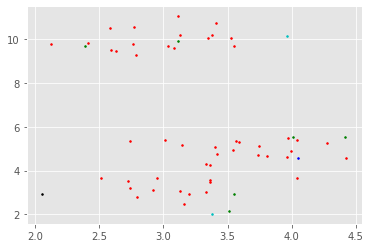

In [152]:
ms = MeanShift()
ms.fit(df)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Estimated clusters:", n_clusters_)
colors = 10*['r.','g.','b.','c.','k.','y.','m.']
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 3)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
    marker=".",color='k', s=20, linewidths = 5, zorder=10)
plt.show()

In [155]:
good_ratings = ["A", "5 Stars", "A+", "A+++"]

df[df_uncleaned["Energy Star"].isin(good_ratings)]

C:\Users\Clarence\AppData\Local\Temp/ipykernel_36024/2093813761.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df_uncleaned["Energy Star"].isin(good_ratings)]


,Price,Screen Size,Display Technology_Full-Array LED-LCD,Display Technology_HD,Display Technology_LCD,Display Technology_LED,Display Technology_OLED,Display Technology_QLED,Display Technology_SMART 4K TV,Maximum Resolution_1080p,...,Maximum Resolution_4K UHD,Maximum Resolution_720P,Maximum Resolution_720p,Maximum Resolution_720p (HD),Maximum Resolution_768p,Maximum Resolution_Full HD LED Smart TV,Maximum Resolution_HD (720p),Maximum Resolution_SMART 4K TV,"Maximum Resolution_SMART LED TV 32""",Maximum Resolution_‎1920 x 1080 pixels
1,-0.956505,-1.069173,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,0.577146,1.506792,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25,-0.777373,-0.410205,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,-0.922922,-1.069173,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
60,-0.419153,0.009138,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,-0.665452,-1.548422,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
63,-0.441564,-0.649829,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
66,-0.419175,-0.649829,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
68,0.474158,-1.069173,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
import math

def closest_clusters(row, cluster_centers): 
    max_idx = 0
    min_dist = float("inf")
    for i, cluster in enumerate(cluster_centers): 
        dist = math.sqrt(sum(map(lambda x: x**2, row - cluster)))
        if dist < min_dist: 
            min_dist = dist 
            idx = i
    return idx

df_classified = df.apply(lambda row: closest_clusters(row, cluster_centers), axis=1) 
        

In [168]:
df_classified

0     0
1     0
3     0
4     0
5     0
6     0
7     1
13    1
14    0
15    0
16    0
17    0
18    0
20    0
21    0
22    0
23    1
24    0
25    0
26    0
27    0
29    0
30    0
32    0
33    0
34    0
35    3
36    0
37    3
38    1
39    0
40    0
41    1
42    0
43    0
44    0
45    0
46    0
48    0
49    0
50    0
51    2
52    4
53    0
54    0
55    0
56    0
57    0
60    0
61    0
62    0
63    0
64    1
65    0
66    0
67    0
68    0
70    0
71    0
dtype: int64

In [167]:
df_classified[df_uncleaned["Energy Star"].isin(good_ratings)]

1     0
13    1
25    0
29    0
60    0
61    0
63    0
66    0
68    0
dtype: int64

In [156]:
cluster_centers

array([[-0.27450281, -0.13217886,  0.        ,  0.        ,  0.        ,
         0.87179487,  0.02564103,  0.1025641 ,  0.        ,  0.02564103,
         0.05128205,  0.66666667,  0.02564103,  0.02564103,  0.        ,
         0.        ,  0.        ,  0.02564103,  0.        ,  0.02564103,
         0.07692308,  0.02564103,  0.02564103,  0.        ,  0.        ,
         0.02564103,  0.        ],
       [ 2.33913541,  1.34205021,  0.        ,  0.        ,  0.        ,
         0.75      ,  0.25      ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.75      ,  0.        ,  0.        ,  0.        ,
         0.25      ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 2.93913713,  3.36388298,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.    

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 32 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Price                                      72 non-null     float64
 1   Screen Size                                72 non-null     object 
 2   Display Technology_Does not apply          72 non-null     uint8  
 3   Display Technology_Full-Array LED-LCD      72 non-null     uint8  
 4   Display Technology_HD                      72 non-null     uint8  
 5   Display Technology_HDR                     72 non-null     uint8  
 6   Display Technology_LCD                     72 non-null     uint8  
 7   Display Technology_LED                     72 non-null     uint8  
 8   Display Technology_ND                      72 non-null     uint8  
 9   Display Technology_OLED                    72 non-null     uint8  
 10  Display Technology_QLED     